In [1]:
import numpy as np
import scipy as sp
import sys,json,os
from scipy.special import erf
from scipy.integrate import quad
from scipy import interpolate
from scipy.interpolate import interp1d
import pickle
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'

sys.path.append('../../project/RECOIL/QEdark-python/')
from QEdark_constants import *
from DM_halo_dist import *

In [2]:
sparcd = json.load(open('../../Accessory/sparc_dict.json','r'))
prior = 'lcdm_reg'

In [3]:
mwgals = ['NGC3953', 'NGC4013', 'NGC4217', 'NGC7814', 'UGC03546', 'UGC05253', 'UGC06614', 'UGC08699']

In [4]:
with open('../Output/data/chains_vdf_dict.pkl','rb') as inpf:
    chains_vdf = pickle.load(inpf)
inpf.close()

In [5]:
chains_vdf['shm']['vesc'] = 544.
chains_vdf['shm']['vcirc'] = 220.

In [7]:
"""
set directories
"""
dataDir = os.getcwd() + '../../project/RECOIL/QEdark-python'
FigDir = os.getcwd() + '../../project/RECOIL/QEdark-python/figs'

In [11]:
dQ = .02*alpha*me_eV #eV
dE = 0.1 # eV
wk = 2/137

## import QEdark data
nq = 900
nE = 500
dataDir = '../../Accessory/'
fcrys = {'Si': np.transpose(np.resize(np.loadtxt(dataDir+'/Si_f2.txt',skiprows=1),(nE,nq))),
         'Ge': np.transpose(np.resize(np.loadtxt(dataDir+'/Ge_f2.txt',skiprows=1),(nE,nq)))}

"""
    materials = {name: [Mcell #eV, Eprefactor, Egap #eV, epsilon #eV, fcrys]}
    N.B. If you generate your own fcrys from QEdark, please remove the factor of "wk/4" below. 
"""
materials = {'Si': [2*28.0855*amu2kg, 2.0, 1.2, 3.8,wk/4*fcrys['Si']], \
             'Ge': [2*72.64*amu2kg, 1.8, 0.7, 2.8,wk/4*fcrys['Ge']]}

def FDM(q_eV,n):
    """
    DM form factor
    n = 0: FDM=1, heavy mediator
    n = 1: FDM~1/q, electric dipole
    n = 2: FDM~1/q^2, light mediator
    """
    return (alpha*me_eV/q_eV)**n

def mu_Xe(mX):
    """
    DM-electron reduced mass
    """
    return mX*me_eV/(mX+me_eV)

def dRdE(material, mX, Ee, FDMn, halo, params, rbyrs):
    """
    differential scattering rate for sigma_e = 1 cm^2
    at a fixed electron energy Ee
    given a DM mass, FDM, halo model
    returns dR/dE [events/kg/year]
    """
    n = FDMn
    if Ee < materials[material][2]: # check if less than Egap
        return 0
    else:
        
        if halo[:3] == 'gal':
            gal = halo[4:]
            if gal == 'shm':
                chaind = chains_vdf['shm']
                rho_X = 0.3*1e9
            else:
                chaind = chains_vdf[rbyrs][gal]
                rho_X = chaind['ρ0']*1e9
            ve = chaind['ve']
            vdf_e = chaind['vdf_e']
            vesc = chaind['vesc']*1e5
            vcirc = chaind['vcirc']*1e5
            vert = (1.05+0.07)*vcirc

        else:
            vcirc, vert, vesc = params
            # vesc = 544.*1e5
        qunit = dQ
        Eunit = dE
        Mcell = materials[material][0]
        Eprefactor = materials[material][1]
        Ei = int(np.floor(Ee*10)) # eV
        rho_X = 0.4*1e9
        prefactor = ccms**2*sec2year*rho_X/mX*1/Mcell*alpha*me_eV**2 / mu_Xe(mX)**2
        array_ = np.zeros(nq)

        for qi in range(1,nq+1):
            q = qi*qunit
            vmin = (q/(2*mX)+Ee/q)*ccms
            if vmin > (vesc+vert)*1.1: # rough estimate for kinematicaly allowed regions
                array_[qi-1] = 0
            else:
                """
                define halo model
                """
                if halo == 'shm':
                    eta = etaSHM(vmin,params) # (cm/s)^-1 
                elif halo == 'tsa':
                    eta = etaTsa(vmin,params)
                elif halo == 'dpl':
                    eta = etaDPL(vmin,params)
                elif halo == 'msw':
                    eta = etaMSW(vmin,params)
                elif halo == 'debris':
                    eta = etaDF(vmin,params)
                elif halo[:3] == 'gal':
                    eta = Eta(vmin*1e-5,ve,vdf_e,chaind['vesc'],chaind['vcirc'])
                else:
                    print("Undefined halo parameter. Options are ['shm','tsa','dpl','msw','debris']")
                """
                define array
                """
                array_[qi-1] = Eprefactor*(1/q)*eta*FDM(q,n)**2*materials[material][4][qi-1, Ei-1]
        return prefactor*np.sum(array_, axis=0) # [(kg-year)^-1]

def dRdne(material, mX, ne, FDMn, halo, params, rbyrs):
    """
    calculates rate for sigmae = 1 cm^2 in the ne bin, 
    assuming fiducial values for binsize 
    Si: 3.8 eV, Ge: 2.9 eV
    return dRdne [events/kg/year]
    """
    Ebin = materials[material][3]
    ## check if ne is defined
    if ne*Ebin > dE*nE:
        print('$n_e$ is out of range, pick a smaller value')
        return 0
    elif ne == 0:
        print('$n_e$ must be > 0')
        return 0
    else:    
        tmpEbin = int(np.floor(Ebin/dE))+1
        tmpdRdE = np.zeros(tmpEbin)

        for i in range(tmpEbin):
            ## add up in bins of [1.2,4.9],[5,8.7],...
            tmpdRdE[i] = dRdE(material, mX, (ne-1)*Ebin+dE*i+materials[material][2], FDMn, halo, params, rbyrs)
        dRdne = np.sum(tmpdRdE, axis = 0)

        return dRdne
def dRdnearray(material, mX, Ebin, FDMn, halo, params, rbyrs):
    """
    calculates rate for sigmae = 1 cm^2, binned in Ebin, 
    return binlist [eV], dRdne [events/kg/year/Ebin]
    """    
    numbins = int(np.floor(nE*dE/Ebin))# calculate number of bins of size Ebin
    binlist = [materials[material][2]+ii*Ebin for ii in range(numbins)]
    tmpEbin = int(np.floor(Ebin/dE))
    tmpdRdE = np.zeros(tmpEbin)
    array_ = np.zeros(numbins)

    for ne in range(numbins-1):
        for i in range(tmpEbin):
            tmpdRdE[i] = dRdE(material, mX, ne*Ebin+dE*i+materials[material][2], FDMn, halo, params, rbyrs)
        array_[ne] = np.sum(tmpdRdE, axis = 0)
        
    return binlist, array_

def Sigmae(mXlist, material, nevents, exposure, ne, FDMn, halo, params, rbyrs):
    """
    cross-section assuming nevents (3 for bkgdfree),
    exposure is in kg-years,
    takes in array of mX in MeV
    returns mX [MeV], sigma_e [cm^2]
    """
#    nevents = 3 # for bkgd free experiment
    sigmae = np.zeros(len(mXlist))
    for iimX in tqdm(range(len(mXlist))):
        mX = mXlist[iimX]*1e6
        if dRdne(material, mX, ne, FDMn, halo, params, rbyrs) == 0:
            sigmae[iimX] = np.nan
        else:
            sigmae[iimX] = nevents/(dRdne(material, mX, ne, FDMn, halo, params, rbyrs)*exposure)
    return mXlist, sigmae

In [12]:
rate = []
params = [220e5,232e5,544e5]
Ee = np.linspace(0,49,50)
for Ee_ in Ee:
    R = dRdE('Si', 1e7, Ee_, FDMn=0, halo='shm', params=params, rbyrs='fixed')
    rate.append(R)

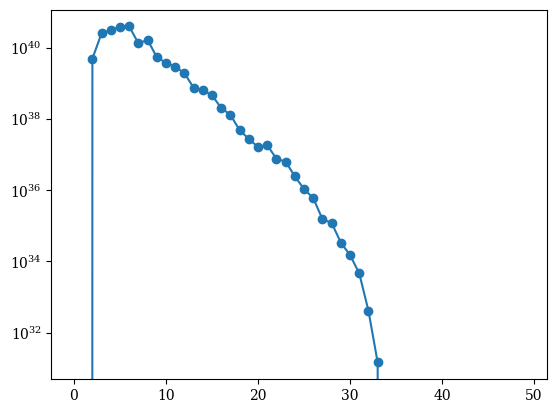

In [15]:
plt.scatter(Ee, rate)
plt.plot(Ee, rate)
plt.yscale('log')

In [11]:
%%time
"""
calculate the rate for fixed number of electrons (ne)
"""
mX = 1e7 # 10 MeV
ne = 1
nFDM = 0
elem = 'Si'
vhalo = 'shm'
vparams = [220e5,232e5,544e5] # cm/s
sigmae=1e-37 # cm2

sigmae*dRdne(elem,mX,ne,nFDM,vhalo,vparams)

TypeError: dRdne() missing 1 required positional argument: 'rbyrs'

In [10]:
%%time
"""
calculate the rate vs ne for specified bin size
n.b. sigmae = 1
dRdneSHMfidarray is [Ee, dRdnearray]
"""
mX = 1e7 # 10 MeV
ne = 1
nFDM = 0
elem = 'Si'
binsize = 3.8 # eV
vhalo = 'gal-shm'
vparams = [220e5,232e5,544e5] # cm/s

dRdneSHMfidarray=dRdnearray(elem,mX,binsize,nFDM,vhalo,params = [],rbyrs = '8kpc')

NameError: name 'chains_vdf' is not defined

In [9]:
%%time
dRdne_mw = dRdnearray(elem,mX,binsize,nFDM,'gal-mw',params = [],rbyrs = '8kpc')

CPU times: user 13.1 s, sys: 0 ns, total: 13.1 s
Wall time: 13.1 s


In [10]:
dRdne_list = []
for gal in tqdm(mwgals):
    ne = 1
    nFDM = 0
    elem = 'Si'
    binsize = 3.8
    vhalo = 'gal-%s'%gal
    dRdne_list.append(dRdnearray(elem,mX,binsize,nFDM,vhalo,params = [],rbyrs = '8kpc'))

  0%|          | 0/8 [00:00<?, ?it/s]

In [11]:
dRdne_y = []
for i in range(8):
    dRdne_ = dRdne_list[i]
    dRdne_y.append(dRdne_[1])
dRdne_y = np.array(dRdne_y)
print (dRdne_y.shape)
dR_min1,dR_max1 = np.percentile(dRdne_y,[16,84],axis = 0)
dR_min2,dR_max2 = np.percentile(dRdne_y,[2,97],axis = 0)

(8, 13)


In [12]:
sigmae = 1e-37

Text(0.5, 0, '$E_e$ [eV]')

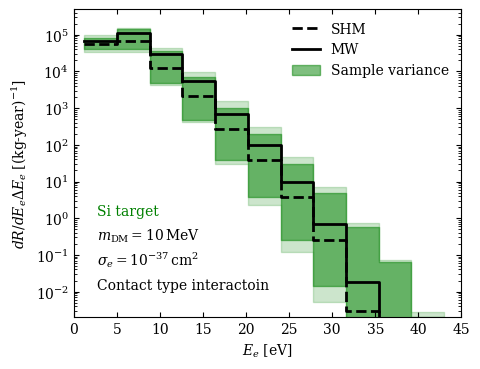

In [13]:
fig,ax = plt.subplots(figsize = (5,4))

color = 'royalblue'
color = 'g'
ax.step(dRdneSHMfidarray[0],sigmae*dRdneSHMfidarray[1],c = 'k', ls = '--',lw = 2,where = 'post',label = 'SHM')
ax.step(dRdne_mw[0],sigmae*dRdne_mw[1],c = 'k', ls = '-',lw = 2,where = 'post', label = 'MW')
ax.fill_between(dRdne_mw[0],sigmae*dR_max1,sigmae*dR_min1, color = color,alpha = 0.5,step = 'post',label = 'Sample variance')
ax.fill_between(dRdne_mw[0],sigmae*dR_max2,sigmae*dR_min2, color = color,alpha = 0.2,step = 'post')
ax.legend(loc = 'upper right', framealpha = 0)
ax.set_yscale('log')
ax.set_ylim(2e-3,5e5)
ax.set_xlim(0,45)
ax.tick_params(which = 'both',direction='in',top=True, right=True)
ax.text(0.06,0.33, 'Si target', color = color, transform = ax.transAxes)
ax.text(0.06,0.25, '$m_{\mathrm{DM}} = 10 \, \mathrm{MeV}$',transform = ax.transAxes)
ax.text(0.06,0.17, '$\sigma_e = 10^{-37}\, \mathrm{cm^{2}}$',transform = ax.transAxes)
ax.text(0.06,0.09, 'Contact type interactoin', transform = ax.transAxes)
ax.set_ylabel(r'$dR/dE_e\Delta E_e$ [(kg-year)$^{-1}$]')
ax.set_xlabel(r'$E_e$ [eV]')


# plt.savefig('../Output/figures/report_plots/electron_recoil_rate_8kpc.pdf',bbox_inches = 'tight',dpi = 300)

In [18]:
%%time
FDMn = 0 # FDM=1
nevents = 3 # for background-free 
exposure = 1 # kg-year
mXlist = np.logspace(-1,3,30) 

σSHM_1 = Sigmae(mXlist, elem, 1, exposure, 1, FDMn, 'gal-shm', [],rbyrs = '8kpc')
σMW_1 = Sigmae(mXlist, elem, 1, exposure, 1, FDMn, 'gal-mw', [],rbyrs = '8kpc')
σMW_2 = Sigmae(mXlist, elem, 2, exposure, 1, FDMn, 'gal-mw', [],rbyrs = '8kpc')

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 2min 15s, sys: 19 ms, total: 2min 15s
Wall time: 2min 15s


In [20]:
σgals = []
for gal in tqdm(mwgals):
    σgals.append(Sigmae(mXlist, elem, 1, exposure, 1, FDMn, 'gal-%s'%gal, [],rbyrs = '8kpc'))

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [21]:
σgals_y = []
for i in range(8):
    σgals_y.append(σgals[i][1])
σgals_y = np.array(σgals_y)
σmin_1,σmax_1 = np.percentile(σgals_y, [16,84],axis = 0)
σmin_2,σmax_2 = np.percentile(σgals_y, [2,97],axis = 0)

Text(0, 0.5, '$\\sigma_e \\,\\, \\mathrm{(cm^{2})}$')

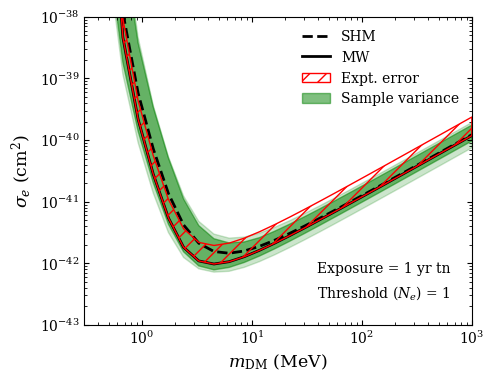

In [22]:
fig,ax = plt.subplots(figsize = (5,4))
color = 'g'
ax.plot(σSHM_1[0], σSHM_1[1], color = 'k', lw = 2, ls = '--',label = 'SHM')
ax.plot(σMW_1[0], σMW_1[1], color = 'k',lw = 2, label = 'MW')
ax.fill_between(σMW_1[0],σMW_1[1],σMW_2[1], color = 'r', hatch = '//', fc = 'None',zorder = 2,label = 'Expt. error')
ax.fill_between(σMW_1[0],σmin_1,σmax_1,color = color, alpha = 0.5, label = 'Sample variance')
ax.fill_between(σMW_1[0],σmin_2,σmax_2,color = color, alpha = 0.2)
ax.legend(loc = 'upper right', framealpha = 0)
ax.text(0.6,0.09, 'Threshold ($N_e$) = 1',transform = ax.transAxes)
ax.text(0.6,0.17, 'Exposure = 1 yr tn', transform = ax.transAxes)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(0.3, 1000)
ax.set_ylim(1.0e-43, 1.0e-38)

ax.tick_params(which = 'both',direction = 'in', right = True, top = True)
ax.set_xlabel('$m_{\mathrm{DM}}\,\, \mathrm{(MeV)}$',size = 12.5)
ax.set_ylabel(r'$\sigma_e \,\, \mathrm{(cm^{2})}$',size = 12.5)

# plt.savefig('../Output/figures/report_plots/electron_recoil_exclusion_8kpc.pdf',bbox_inches = 'tight', dpi = 300)

In [ ]:
%%time
dRdneSHM_rbyrs = dRdnearray(elem,mX,binsize,nFDM,'gal-shm',params = [],rbyrs = 'rbyrsun')
dRdne_mw_rbyrs = dRdnearray(elem,mX,binsize,nFDM,'gal-mw',params = [],rbyrs = 'rbyrsun')

In [ ]:
dRdne_rbyrs_list = []
for gal in tqdm(mwgals):
    ne = 1
    nFDM = 0
    elem = 'Si'
    binsize = 3.8
    vhalo = 'gal-%s'%gal
    dRdne_rbyrs_list.append(dRdnearray(elem,mX,binsize,nFDM,vhalo,params = [],rbyrs = 'rbyrsun'))

In [ ]:
dRdne_rbyrs_y = []
for i in range(8):
    dRdne_rbyrs_ = dRdne_rbyrs_list[i]
    dRdne_rbyrs_y.append(dRdne_rbyrs_[1])
dRdne_rbyrs_y = np.array(dRdne_rbyrs_y)
print (dRdne_rbyrs_y.shape)
dR_rbyrs_min1,dR_rbyrs_max1 = np.percentile(dRdne_rbyrs_y,[16,84],axis = 0)
dR_rbyrs_min2,dR_rbyrs_max2 = np.percentile(dRdne_rbyrs_y,[2,97],axis = 0)

In [ ]:
fig,ax = plt.subplots(figsize = (5,4))

color = 'royalblue'
color = 'g'
ax.step(dRdneSHM_rbyrs[0],sigmae*dRdneSHM_rbyrs[1],c = 'k', ls = '--',lw = 2,where = 'post',label = 'SHM')
ax.step(dRdne_mw_rbyrs[0],sigmae*dRdne_mw_rbyrs[1],c = 'k', ls = '-',lw = 2,where = 'post', label = 'MW')
ax.fill_between(dRdne_mw_rbyrs[0],sigmae*dR_rbyrs_max1,sigmae*dR_rbyrs_min1, color = color,alpha = 0.5,step = 'post',label = 'Sample variance')
ax.fill_between(dRdne_mw_rbyrs[0],sigmae*dR_rbyrs_max2,sigmae*dR_rbyrs_min2, color = color,alpha = 0.2,step = 'post')
ax.legend(loc = 'upper right', framealpha = 0)
ax.set_yscale('log')
ax.set_ylim(2e-3,5e5)
ax.set_xlim(0,45)
ax.tick_params(which = 'both',direction='in',top=True, right=True)
ax.text(0.06,0.33, 'Si target', color = color, transform = ax.transAxes)
ax.text(0.06,0.25, '$m_{\mathrm{DM}} = 10 \, \mathrm{MeV}$',transform = ax.transAxes)
ax.text(0.06,0.17, '$\sigma_e = 10^{-37}\, \mathrm{cm^{2}}$',transform = ax.transAxes)
ax.text(0.06,0.09, 'Contact type interactoin', transform = ax.transAxes)
ax.set_ylabel(r'$dR/dE_e\Delta E_e$ [(kg-year)$^{-1}$]')
ax.set_xlabel(r'$E_e$ [eV]')


# plt.savefig('../Output/figures/report_plots/electron_recoil_rate_rbyrsun.pdf',bbox_inches = 'tight',dpi = 300)

In [ ]:
%%time

σSHM_rbyrs_1 = Sigmae(mXlist, elem, 1, exposure, 1, FDMn, 'gal-shm', [], 'rbyrsun')
σMW_rbyrs_1 = Sigmae(mXlist, elem, 1, exposure, 1, FDMn, 'gal-mw', [], 'rbyrsun')
σMW_rbyrs_2 = Sigmae(mXlist, elem, 2, exposure, 1, FDMn, 'gal-mw', [], 'rbyrsun')

In [ ]:
σgals_rbyrs = []
for gal in tqdm(mwgals):
    σgals_rbyrs.append(Sigmae(mXlist, elem, 1, exposure, 1, FDMn, 'gal-%s'%gal, [], 'rbyrsun'))

In [ ]:
σgals_rbyrs_y = []
for i in range(8):
    σgals_rbyrs_y.append(σgals_rbyrs[i][1])
σgals_rbyrs_y = np.array(σgals_rbyrs_y)
σmin_rbyrs_1,σmax_rbyrs_1 = np.percentile(σgals_rbyrs_y, [16,84],axis = 0)
σmin_rbyrs_2,σmax_rbyrs_2 = np.percentile(σgals_rbyrs_y, [2,97],axis = 0)

In [ ]:
fig,ax = plt.subplots(figsize = (5,4))
color = 'g'
ax.plot(σSHM_rbyrs_1[0], σSHM_rbyrs_1[1], color = 'k', lw = 2, ls = '--',label = 'SHM')
ax.plot(σMW_rbyrs_1[0], σMW_rbyrs_1[1], color = 'k',lw = 2, label = 'MW')
ax.fill_between(σMW_rbyrs_1[0],σMW_rbyrs_1[1],σMW_rbyrs_2[1], color = 'r', hatch = '//', fc = 'None',zorder = 2,label = 'Expt. error')
ax.fill_between(σMW_rbyrs_1[0],σmin_rbyrs_1,σmax_rbyrs_1,color = color, alpha = 0.5, label = 'Sample variance')
ax.fill_between(σMW_rbyrs_1[0],σmin_rbyrs_2,σmax_rbyrs_2,color = color, alpha = 0.2)
ax.legend(loc = 'upper right', framealpha = 0)
ax.text(0.6,0.09, 'Threshold ($N_e$) = 1',transform = ax.transAxes)
ax.text(0.6,0.17, 'Exposure = 1 yr tn', transform = ax.transAxes)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(0.3, 1000)
ax.set_ylim(1.0e-43, 1.0e-38)

ax.tick_params(which = 'both',direction = 'in', right = True, top = True)
ax.set_xlabel('$m_{\mathrm{DM}}\,\, \mathrm{(MeV)}$',size = 12.5)
ax.set_ylabel(r'$\sigma_e \,\, \mathrm{(cm^{2})}$',size = 12.5)

# plt.savefig('../Output/figures/report_plots/electron_recoil_exclusion_rbyrsun.pdf',bbox_inches = 'tight', dpi = 300)

In [36]:
expts = ['DAMIC-M','XENON1T','PandaX-II','DarkSide-50']
colors = ['pink','g','orange','grey']
ERexptEx = {}
i = 0
for expt in expts:
    ERexptEx[expt] = {}
    filename = '../../Lit_review/DD/Ex_plots/ER_%s.dat'%expt
    data = np.loadtxt(filename,delimiter = ',')
    func = sp.interpolate.interp1d(data[:,0],data[:,1],kind = 'linear',
                                   bounds_error = False,fill_value = 'extrapolate')
    ERexptEx[expt]['mean'] = func
    ERexptEx[expt]['mdm_lim'] = [data[:,0][0],data[:,0][-1]]
    ERexptEx[expt]['color'] = colors[i]
    i += 1

In [31]:
for expt in expts:
    # print (ERexptEx[expt]['mdm_lim'])
    print 

[0.5357383947673271, 922.767738519987]
[5.085872905486944, 808.346451044848]
[0.5357383947673271, 95.38193289989393]
[5.038006539595663, 896.9579302182335]
[13.093119182791625, 905.4799748284329]


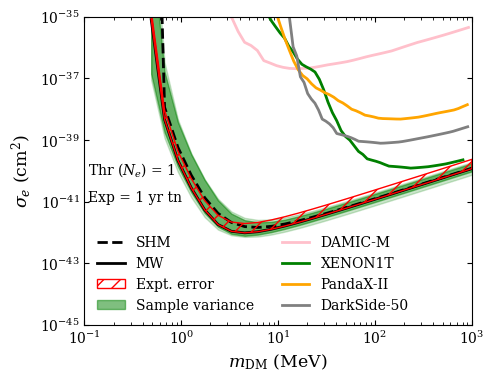

In [48]:
fig,ax = plt.subplots(figsize = (5,4))
color = 'g'
ax.plot(σSHM_1[0], σSHM_1[1], color = 'k', lw = 2, ls = '--',label = 'SHM')
ax.plot(σMW_1[0], σMW_1[1], color = 'k',lw = 2, label = 'MW')
ax.fill_between(σMW_1[0],σMW_1[1],σMW_2[1], color = 'r', hatch = '//', fc = 'None',zorder = 2,label = 'Expt. error')
ax.fill_between(σMW_1[0],σmin_1,σmax_1,color = color, alpha = 0.5, label = 'Sample variance')
ax.fill_between(σMW_1[0],σmin_2,σmax_2,color = color, alpha = 0.2)

ax.text(0.01,0.49, 'Thr ($N_e$) = 1',transform = ax.transAxes)
ax.text(0.01,0.40, 'Exp = 1 yr tn', transform = ax.transAxes)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(1e-1, 1000)
# ax.set_ylim(1.0e-43, 1.0e-38)
ax.set_ylim(1e-45,1e-35)

for expt in expts:
    erd = ERexptEx[expt]
    lim = erd['mdm_lim']
    mdm = np.logspace(*np.log10(lim),50)
    mean = erd['mean'](mdm)
    ax.plot(mdm,mean,color = erd['color'], lw= 2,label = expt)
ax.legend(loc = 'lower left', framealpha = 0,ncols = 2)

ax.tick_params(which = 'both',direction = 'in', right = True, top = True)
ax.set_xlabel('$m_{\mathrm{DM}}\,\, \mathrm{(MeV)}$',size = 12.5)
ax.set_ylabel(r'$\sigma_e \,\, \mathrm{(cm^{2})}$',size = 12.5)

plt.savefig('../Output/figures/report_plots/electron_recoil_exclusion_8kpc_with_expt.pdf',bbox_inches = 'tight', dpi = 300)